In [34]:
import pandas as pd 
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

In [2]:
"""train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test.drop(["Clearsky DHI","Clearsky DNI","Clearsky GHI"],axis=1,inplace=True)
test_y = pd.read_csv("sample_submission.csv")
correlated_Columns = ["Clearsky DHI","Clearsky DNI","Solar Zenith Angle","Temperature"]
test = pd.concat([test,test_y],axis=1)"""

'train = pd.read_csv("train.csv")\ntest = pd.read_csv("test.csv")\ntest.drop(["Clearsky DHI","Clearsky DNI","Clearsky GHI"],axis=1,inplace=True)\ntest_y = pd.read_csv("sample_submission.csv")\ncorrelated_Columns = ["Clearsky DHI","Clearsky DNI","Solar Zenith Angle","Temperature"]\ntest = pd.concat([test,test_y],axis=1)'

In [3]:
data = pd.read_csv("train.csv")
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = data.iloc[0:train_size], data.iloc[train_size:len(data)]

In [4]:
Scaler = MinMaxScaler()

In [5]:
train_GHI = train["Clearsky GHI"].values
train.drop(["Clearsky GHI"],axis=1,inplace=True)
#train.drop(correlated_Columns,axis=1,inplace=True)
test_GHI = test["Clearsky GHI"].values

test.drop(["Clearsky GHI"],axis=1,inplace=True)
#test.drop(correlated_Columns,axis=1,inplace=True)



C:\Users\burak\AppData\Local\Temp/ipykernel_11332/986303468.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(["Clearsky GHI"],axis=1,inplace=True)
C:\Users\burak\AppData\Local\Temp/ipykernel_11332/986303468.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(["Clearsky GHI"],axis=1,inplace=True)


In [6]:
train

,Year,Month,Day,Hour,Minute,Clearsky DHI,Clearsky DNI,Cloud Type,Dew Point,Temperature,Pressure,Relative Humidity,Solar Zenith Angle,Precipitable Water,Wind Direction,Wind Speed,Fill Flag
0,2009,1,1,0,0,0,0,0,0.0,5.0,1010,75.34,106.15,0.499,346.1,3.1,0
1,2009,1,1,0,30,0,0,0,1.0,5.0,1010,80.81,112.28,0.490,346.1,3.1,0
2,2009,1,1,1,0,0,0,4,0.0,5.0,1010,78.27,118.50,0.482,347.9,3.2,0
3,2009,1,1,1,30,0,0,4,0.0,4.0,1010,78.27,124.78,0.478,347.9,3.1,0
4,2009,1,1,2,0,0,0,4,0.0,4.0,1010,76.45,131.12,0.475,350.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140231,2016,12,31,11,30,0,0,0,-2.0,1.0,1010,78.02,103.65,1.156,162.3,0.9,1
140232,2016,12,31,12,0,0,0,0,-2.0,1.0,1010,78.56,97.69,1.199,158.2,1.0,1
140233,2016,12,31,12,30,0,0,0,-2.0,2.0,1010,73.13,91.88,1.261,158.2,1.1,1
140234,2016,12,31,13,0,23,285,0,-1.0,3.0,1010,74.55,86.26,1.323,155.0,1.3,1


In [7]:
train["Datetime"] = pd.to_datetime(train[['Year', 'Month', 'Day', 'Hour', 'Minute']])
test["Datetime"] = pd.to_datetime(test[['Year', 'Month', 'Day', 'Hour', 'Minute']])

C:\Users\burak\AppData\Local\Temp/ipykernel_11332/3499051208.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Datetime"] = pd.to_datetime(train[['Year', 'Month', 'Day', 'Hour', 'Minute']])
C:\Users\burak\AppData\Local\Temp/ipykernel_11332/3499051208.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Datetime"] = pd.to_datetime(test[['Year', 'Month', 'Day', 'Hour', 'Minute']])


In [8]:
train.set_index("Datetime",inplace=True)
test.set_index("Datetime",inplace=True)

In [9]:
train.drop(["Year","Month","Day","Hour","Minute"],axis=1,inplace=True)
test.drop(["Year","Month","Day","Hour","Minute"],axis=1,inplace=True)

C:\Users\burak\AppData\Local\Temp/ipykernel_11332/2400044252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(["Year","Month","Day","Hour","Minute"],axis=1,inplace=True)
C:\Users\burak\AppData\Local\Temp/ipykernel_11332/2400044252.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(["Year","Month","Day","Hour","Minute"],axis=1,inplace=True)


In [10]:
train = Scaler.fit_transform(train)
test = Scaler.fit_transform(test)

train_GHI = Scaler.fit_transform(train_GHI.reshape(-1,1))
test_GHI = Scaler.fit_transform(test_GHI.reshape(-1,1))

In [11]:
def createSequence(data,window_size):
    sequences = []
    for i in range(0,len(data) - window_size +1):
        sequence = data[i:i+window_size]
        sequences.append(sequence)
    return np.array(sequences)

sequences_96 = createSequence(train,window_size=96) # 2 day

In [45]:
train_GHI_96  = createSequence(train_GHI,window_size=96)
test_GHI_96 = createSequence(test_GHI,window_size=96)

In [13]:
def createModel(lr):
    model = Sequential()
    model.add(LSTM(32,input_shape=(96,12),return_sequences=True))
    #model.add(LSTM(64))
    model.add(Dense(16,activation="relu"))
    model.add(Dense(1,activation="relu"))
    model.compile(loss="mse",optimizer=Adam(learning_rate=lr),metrics=["mse"])
    return model

In [56]:
dummy_model = createModel(1)
dummy_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 96, 32)            5760      
                                                                 
 dense_18 (Dense)            (None, 96, 16)            528       
                                                                 
 dense_19 (Dense)            (None, 96, 1)             17        
                                                                 
Total params: 6,305
Trainable params: 6,305
Non-trainable params: 0
_________________________________________________________________


In [14]:
lr = [0.001,0.0001,0.00001]
batch_size = [16,32]

In [15]:
m1 = createModel(lr[0])
m2 = createModel(lr[0])
m3 = createModel(lr[1])
m4 = createModel(lr[1])
m5 = createModel(lr[2])
m6 = createModel(lr[2])

In [16]:
hist1 = m1.fit(sequences_96,train_GHI_96,epochs=5,batch_size=batch_size[0],validation_split=0.2)

Epoch 1/5
7007/7007 [==============================] - 117s 16ms/step - loss: 5.8659e-04 - mse: 5.8659e-04 - val_loss: 1.9484e-05 - val_mse: 1.9484e-05
Epoch 2/5
7007/7007 [==============================] - 113s 16ms/step - loss: 1.2308e-05 - mse: 1.2308e-05 - val_loss: 6.7892e-06 - val_mse: 6.7892e-06
Epoch 3/5
7007/7007 [==============================] - 109s 16ms/step - loss: 5.3034e-06 - mse: 5.3034e-06 - val_loss: 2.8445e-06 - val_mse: 2.8445e-06
Epoch 4/5
7007/7007 [==============================] - 105s 15ms/step - loss: 3.2192e-06 - mse: 3.2192e-06 - val_loss: 2.2758e-06 - val_mse: 2.2758e-06
Epoch 5/5
7007/7007 [==============================] - 99s 14ms/step - loss: 2.3320e-06 - mse: 2.3320e-06 - val_loss: 1.0960e-06 - val_mse: 1.0960e-06


In [17]:
hist2 = m2.fit(sequences_96,train_GHI_96,epochs=5,batch_size=batch_size[1],validation_split=0.2)

Epoch 1/5
3504/3504 [==============================] - 49s 14ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 4.8892e-05 - val_mse: 4.8892e-05
Epoch 2/5
3504/3504 [==============================] - 60s 17ms/step - loss: 2.3344e-05 - mse: 2.3344e-05 - val_loss: 3.3915e-05 - val_mse: 3.3915e-05
Epoch 3/5
3504/3504 [==============================] - 64s 18ms/step - loss: 1.1352e-05 - mse: 1.1352e-05 - val_loss: 9.2360e-06 - val_mse: 9.2360e-06
Epoch 4/5
3504/3504 [==============================] - 65s 19ms/step - loss: 7.1763e-06 - mse: 7.1763e-06 - val_loss: 5.4487e-06 - val_mse: 5.4487e-06
Epoch 5/5
3504/3504 [==============================] - 64s 18ms/step - loss: 5.0317e-06 - mse: 5.0317e-06 - val_loss: 8.4150e-06 - val_mse: 8.4150e-06


In [18]:
hist3 = m3.fit(sequences_96,train_GHI_96,epochs=5,batch_size=batch_size[0],validation_split=0.2)

Epoch 1/5
7007/7007 [==============================] - 127s 18ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 2.9926e-04 - val_mse: 2.9926e-04
Epoch 2/5
7007/7007 [==============================] - 122s 17ms/step - loss: 1.1807e-04 - mse: 1.1807e-04 - val_loss: 4.8021e-05 - val_mse: 4.8021e-05
Epoch 3/5
7007/7007 [==============================] - 121s 17ms/step - loss: 3.1565e-05 - mse: 3.1565e-05 - val_loss: 2.2617e-05 - val_mse: 2.2617e-05
Epoch 4/5
7007/7007 [==============================] - 120s 17ms/step - loss: 1.7161e-05 - mse: 1.7161e-05 - val_loss: 1.3393e-05 - val_mse: 1.3393e-05
Epoch 5/5
7007/7007 [==============================] - 117s 17ms/step - loss: 1.1363e-05 - mse: 1.1363e-05 - val_loss: 1.0377e-05 - val_mse: 1.0377e-05


In [19]:
hist4 = m4.fit(sequences_96,train_GHI_96,epochs=5,batch_size=batch_size[1],validation_split=0.2)

Epoch 1/5
3504/3504 [==============================] - 67s 18ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 6.7777e-04 - val_mse: 6.7777e-04
Epoch 2/5
3504/3504 [==============================] - 66s 19ms/step - loss: 3.1194e-04 - mse: 3.1194e-04 - val_loss: 1.4134e-04 - val_mse: 1.4134e-04
Epoch 3/5
3504/3504 [==============================] - 62s 18ms/step - loss: 7.7809e-05 - mse: 7.7809e-05 - val_loss: 4.6810e-05 - val_mse: 4.6810e-05
Epoch 4/5
3504/3504 [==============================] - 64s 18ms/step - loss: 2.8798e-05 - mse: 2.8798e-05 - val_loss: 2.0520e-05 - val_mse: 2.0520e-05
Epoch 5/5
3504/3504 [==============================] - 66s 19ms/step - loss: 1.4937e-05 - mse: 1.4937e-05 - val_loss: 1.2070e-05 - val_mse: 1.2070e-05


In [20]:
hist5 = m5.fit(sequences_96,train_GHI_96,epochs=5,batch_size=batch_size[0],validation_split=0.2)

Epoch 1/5
7007/7007 [==============================] - 134s 19ms/step - loss: 0.0154 - mse: 0.0154 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 2/5
7007/7007 [==============================] - 119s 17ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 9.6043e-04 - val_mse: 9.6043e-04
Epoch 3/5
7007/7007 [==============================] - 122s 17ms/step - loss: 6.4744e-04 - mse: 6.4744e-04 - val_loss: 4.7897e-04 - val_mse: 4.7897e-04
Epoch 4/5
7007/7007 [==============================] - 120s 17ms/step - loss: 3.6674e-04 - mse: 3.6675e-04 - val_loss: 3.0610e-04 - val_mse: 3.0610e-04
Epoch 5/5
7007/7007 [==============================] - 119s 17ms/step - loss: 2.4791e-04 - mse: 2.4791e-04 - val_loss: 2.1877e-04 - val_mse: 2.1877e-04


In [21]:
hist6 = m6.fit(sequences_96,train_GHI_96,epochs=5,batch_size=batch_size[1],validation_split=0.2)

Epoch 1/5
3504/3504 [==============================] - 62s 17ms/step - loss: 0.0392 - mse: 0.0392 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 2/5
3504/3504 [==============================] - 60s 17ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 3/5
3504/3504 [==============================] - 60s 17ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 4/5
3504/3504 [==============================] - 59s 17ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 8.6443e-04 - val_mse: 8.6443e-04
Epoch 5/5
3504/3504 [==============================] - 62s 18ms/step - loss: 6.5920e-04 - mse: 6.5920e-04 - val_loss: 5.3392e-04 - val_mse: 5.3392e-04


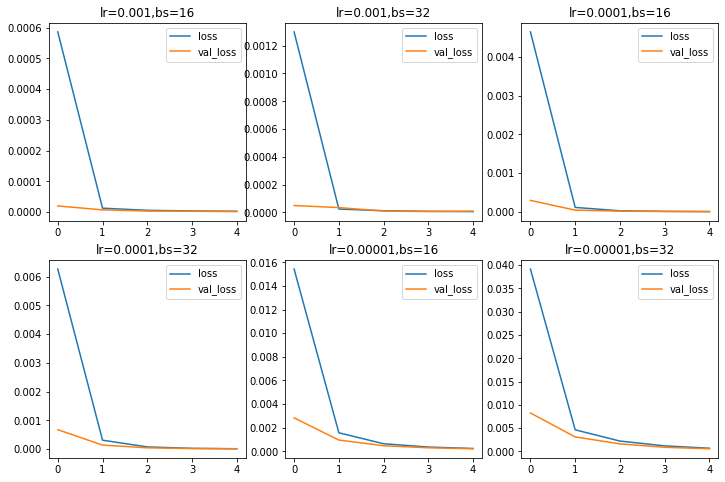

In [22]:
fig = plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.plot(hist1.history["loss"],label="loss")
plt.plot(hist1.history["val_loss"],label="val_loss")
plt.title("lr=0.001,bs=16")
plt.legend()
plt.subplot(2,3,2)
plt.plot(hist2.history["loss"],label="loss")
plt.plot(hist2.history["val_loss"],label="val_loss")
plt.title("lr=0.001,bs=32")
plt.legend()
plt.subplot(2,3,3)
plt.plot(hist3.history["loss"],label="loss")
plt.plot(hist3.history["val_loss"],label="val_loss")
plt.title("lr=0.0001,bs=16")
plt.legend()
plt.subplot(2,3,4)
plt.plot(hist4.history["loss"],label="loss")
plt.plot(hist4.history["val_loss"],label="val_loss")
plt.title("lr=0.0001,bs=32")
plt.legend()
plt.subplot(2,3,5)
plt.plot(hist5.history["loss"],label="loss")
plt.plot(hist5.history["val_loss"],label="val_loss")
plt.title("lr=0.00001,bs=16")
plt.legend()
plt.subplot(2,3,6)
plt.plot(hist6.history["loss"],label="loss")
plt.plot(hist6.history["val_loss"],label="val_loss")
plt.title("lr=0.00001,bs=32")
plt.legend()
plt.show()

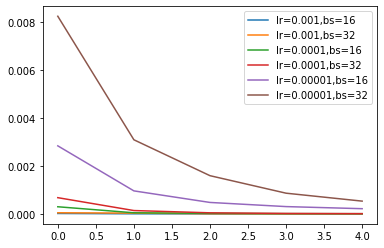

In [23]:
plt.plot(hist1.history["val_loss"],label="lr=0.001,bs=16")
plt.plot(hist2.history["val_loss"],label="lr=0.001,bs=32")
plt.plot(hist3.history["val_loss"],label="lr=0.0001,bs=16")
plt.plot(hist4.history["val_loss"],label="lr=0.0001,bs=32")
plt.plot(hist5.history["val_loss"],label="lr=0.00001,bs=16")
plt.plot(hist6.history["val_loss"],label="lr=0.00001,bs=32")
plt.legend()


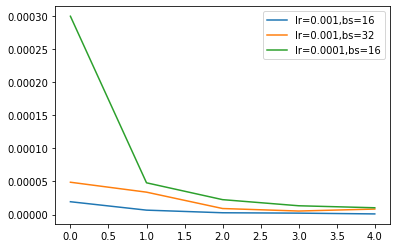

In [24]:
plt.plot(hist1.history["val_loss"],label="lr=0.001,bs=16")
plt.plot(hist2.history["val_loss"],label="lr=0.001,bs=32")
plt.plot(hist3.history["val_loss"],label="lr=0.0001,bs=16")
#plt.plot(hist4.history["val_loss"],label="lr=0.0001,bs=32")
plt.legend()
plt.show()

### First setting gives the lowest validation error. (Learning rate = 0.001 , batch_size = 16)

In [25]:
best_model = createModel(lr = 0.001)
hist_b = best_model.fit(sequences_96,train_GHI_96,epochs=20,batch_size=16,validation_split=0.2)

Epoch 1/20
7007/7007 [==============================] - 115s 16ms/step - loss: 6.6649e-04 - mse: 6.6649e-04 - val_loss: 1.9183e-05 - val_mse: 1.9183e-05
Epoch 2/20
7007/7007 [==============================] - 110s 16ms/step - loss: 1.1582e-05 - mse: 1.1582e-05 - val_loss: 5.2289e-06 - val_mse: 5.2289e-06
Epoch 3/20
7007/7007 [==============================] - 117s 17ms/step - loss: 5.9027e-06 - mse: 5.9027e-06 - val_loss: 2.5672e-06 - val_mse: 2.5672e-06
Epoch 4/20
7007/7007 [==============================] - 97s 14ms/step - loss: 3.9729e-06 - mse: 3.9729e-06 - val_loss: 2.0635e-06 - val_mse: 2.0635e-06
Epoch 5/20
7007/7007 [==============================] - 100s 14ms/step - loss: 2.8255e-06 - mse: 2.8255e-06 - val_loss: 7.8710e-06 - val_mse: 7.8710e-06
Epoch 6/20
7007/7007 [==============================] - 108s 15ms/step - loss: 2.2005e-06 - mse: 2.2005e-06 - val_loss: 1.8112e-06 - val_mse: 1.8112e-06
Epoch 7/20
7007/7007 [==============================] - 107s 15ms/step - loss: 1.86

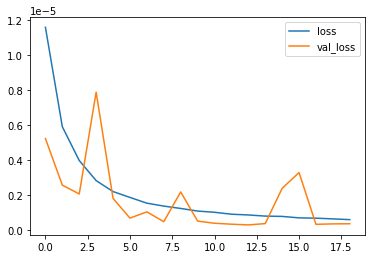

In [28]:
plt.plot(hist_b.history["loss"][1:],label="loss")
plt.plot(hist_b.history["val_loss"][1:],label="val_loss")
plt.legend()
plt.show()

In [31]:
predictions = best_model.predict(createSequence(test,window_size=96))



1093/1093 [==============================] - 8s 7ms/step


In [50]:
test_GHI_96 = test_GHI_96.reshape((test_GHI_96.shape[0],test_GHI_96.shape[1]))
predictions = predictions.reshape((predictions.shape[0],predictions.shape[1]))



mse = mean_squared_error(test_GHI_96,predictions)

print(mse)

0.0006758569247773029


In [54]:
tf.keras.models.save_model(best_model,"best_model_LSTM.h5")